In [1]:
import torch
import torchvision
from torchvision.ops import nms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np


In [2]:
num_classes = 3

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

In [4]:
in_features = model.roi_heads.box_predictor.cls_score.in_features


In [5]:
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
model.load_state_dict(torch.load('faster_rcnn_model.pth', map_location=device))


/tmp/ipykernel_6076/4161302905.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('faster_rcnn_model.pth', map_location=device))


<All keys matched successfully>

In [8]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [9]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [10]:
img_path = 'BD_Joing/train/53586896_jpg.rf.e8c393b905341702df5088dc0f372d1e.jpg'

In [11]:
img = Image.open(img_path).convert("RGB")
transform = torchvision.transforms.ToTensor()
img_tensor = transform(img).to(device)


In [12]:
with torch.no_grad():
    prediction = model([img_tensor])

In [13]:
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

In [14]:
score_threshold = 0.4
keep = scores >= score_threshold

In [15]:
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]

In [ ]:
nms_threshold = 0.4
indices = nms(boxes, scores, nms_threshold)

In [17]:
boxes = boxes[indices]
labels = labels[indices]
scores = scores[indices]

In [18]:
boxes = boxes.cpu()
labels = labels.cpu()
scores = scores.cpu()

In [19]:
img_with_boxes = img.copy()
draw = ImageDraw.Draw(img_with_boxes)


In [ ]:
try:
    font = ImageFont.truetype("arial.ttf", size=15)
except IOError:
    font = ImageFont.load_default()

In [ ]:
labels_map = {1: 'Mass'}

for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

    # Desenha o retângulo da caixa
    draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='blue', width=2)

    # Obtem o nome da classe
    class_name = labels_map.get(label.item(), 'desconhecido')

    # Cria o texto com o label e o score
    text = f"{class_name}: {score.item():.2f}"

    # Calcula a posição e o tamanho do texto
    text_size = draw.textbbox((0, 0), text, font=font)
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]

    # Coordenadas do fundo do texto
    text_xmin = xmin
    text_ymin = ymin - text_height - 5  # Ajustar conforme necessário
    text_xmax = xmin + text_width
    text_ymax = ymin

    # Garante que o texto não saia da imagem
    if text_ymin < 0:
        text_ymin = ymin
        text_ymax = ymin + text_height + 5

    # Desenha o retângulo de fundo
    draw.rectangle([(text_xmin, text_ymin), (text_xmax, text_ymax)], fill='blue')

    # Escreve o texto sobre o fundo
    draw.text((text_xmin, text_ymin), text, fill='white', font=font)

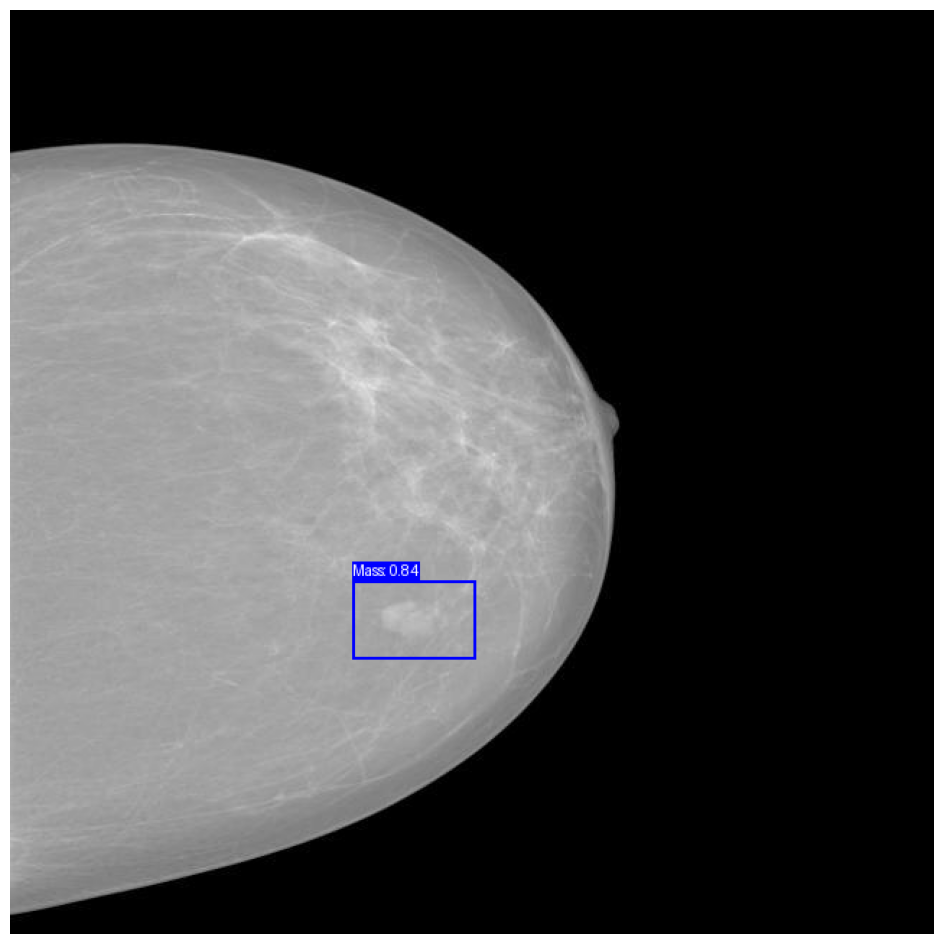

In [22]:
plt.figure(figsize=(20,12))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()